In [4]:
import yfinance as yf
import pandas as pd

# Define tickers and time period
tickers = ['SPY', 'AAPL']
start_date = '2010-01-01'
end_date = '2025-09-30'

# Download data
data = yf.download(tickers, start=start_date, end=end_date)

if isinstance(data.columns, pd.MultiIndex):
    adj_close = data['Close']                  # adjusted closes
else:
    adj_close = data[['Close']].rename(columns={'Close': tickers[0]})


/var/folders/9z/26jz_ql9507379s_bv_2qyq40000gn/T/ipykernel_81973/1666811093.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  2 of 2 completed


In [15]:
import yfinance as yf
import pandas as pd
import numpy as np

def download_ohlc(tickers, start='2010-01-01', end=None):
    data = yf.download(list(tickers), start=start, end=end, auto_adjust=True, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        out = {tk: data.xs(tk, axis=1, level=1)[['Open','High','Low','Close']].dropna()
               for tk in tickers}
    else:  # single ticker
        tk = tickers[0] if isinstance(tickers, (list, tuple)) else tickers
        out = {tk: data[['Open','High','Low','Close']].dropna()}
    return out

def tally_trailing_triggers(df, thresholds=(0.05, 0.10, 0.15)):
    c = df['Close']
    roll_max = c.cummax()
    dd = c / roll_max - 1.0  # negative when below the running high

    rows = []
    dates_map = {}
    for t in thresholds:
        crossed = (dd <= -t) & (dd.shift(1) > -t)  # first day it breaches that level
        dates = list(dd.index[crossed])
        rows.append({'Threshold %': int(t*100), '# Triggers': len(dates)})
        dates_map[int(t*100)] = dates
    return pd.DataFrame(rows), dates_map

def tally_fixed_from_entry(df, thresholds=(0.05, 0.10, 0.15)):
    c = df['Close']
    entry = c.iloc[0]
    stops = {int(t*100): entry * (1 - t) for t in thresholds}
    out = []
    dates_map = {}
    for pct, stop_level in stops.items():
        hit = (df['Low'] <= stop_level)
        if hit.any():
            first_date = df.index[hit.values.argmax()]  # first True
            out.append({'Threshold %': pct, '# Triggers': 1})
            dates_map[pct] = [first_date]
        else:
            out.append({'Threshold %': pct, '# Triggers': 0})
            dates_map[pct] = []
    return pd.DataFrame(out), dates_map

def summarize_tallies(tickers=('SPY','AAPL'), start='2010-01-01', mode='trailing'):
    data = download_ohlc(tickers, start=start)
    rows = []
    dates_by_ticker = {}
    for tk, df in data.items():
        if mode == 'trailing':
            tbl, dates = tally_trailing_triggers(df, thresholds=(0.05,0.10,0.15))
        elif mode == 'fixed':
            tbl, dates = tally_fixed_from_entry(df, thresholds=(0.05,0.10,0.15))
        else:
            raise ValueError("mode must be 'trailing' or 'fixed'")
        tbl.insert(0, 'Ticker', tk)
        rows.append(tbl)
        dates_by_ticker[tk] = dates
    summary = pd.concat(rows, ignore_index=True)
    return summary, dates_by_ticker



    

In [16]:
summary_trailing, dates_trailing = summarize_tallies(('SPY','AAPL'), start='2010-01-01', mode='trailing')
print(summary_trailing); dates_trailing['SPY'][5]  # list of dates when 5% trailing stop was triggered

  Ticker  Threshold %  # Triggers
0    SPY            5          65
1    SPY           10          37
2    SPY           15          29
3   AAPL            5         114
4   AAPL           10          85
5   AAPL           15          51


[Timestamp('2010-01-22 00:00:00'),
 Timestamp('2010-01-28 00:00:00'),
 Timestamp('2010-02-04 00:00:00'),
 Timestamp('2010-05-06 00:00:00'),
 Timestamp('2010-05-14 00:00:00'),
 Timestamp('2010-09-27 00:00:00'),
 Timestamp('2010-09-29 00:00:00'),
 Timestamp('2010-10-04 00:00:00'),
 Timestamp('2011-03-16 00:00:00'),
 Timestamp('2011-06-06 00:00:00'),
 Timestamp('2011-06-22 00:00:00'),
 Timestamp('2011-08-01 00:00:00'),
 Timestamp('2011-10-31 00:00:00'),
 Timestamp('2012-05-14 00:00:00'),
 Timestamp('2012-06-21 00:00:00'),
 Timestamp('2012-07-12 00:00:00'),
 Timestamp('2012-07-24 00:00:00'),
 Timestamp('2012-11-08 00:00:00'),
 Timestamp('2013-06-24 00:00:00'),
 Timestamp('2014-02-03 00:00:00'),
 Timestamp('2014-10-10 00:00:00'),
 Timestamp('2015-08-21 00:00:00'),
 Timestamp('2015-10-13 00:00:00'),
 Timestamp('2016-01-06 00:00:00'),
 Timestamp('2016-03-08 00:00:00'),
 Timestamp('2016-06-27 00:00:00'),
 Timestamp('2018-02-05 00:00:00'),
 Timestamp('2018-02-20 00:00:00'),
 Timestamp('2018-02-

,Ticker,CAGR %,Sharpe,Max Drawdown %,Longest Recovery (days)
0,AAPL,26.33,0.97,-43.8,453
1,SPY,14.01,0.85,-33.7,488


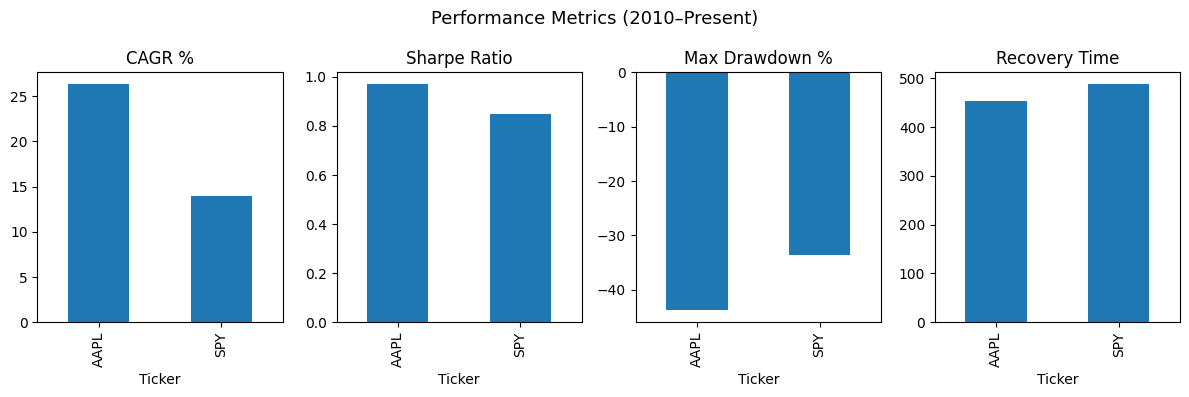

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Download ----------
def get_prices(tickers=('SPY','AAPL'), start='2010-01-01', end=None):
    data = yf.download(list(tickers), start=start, end=end, auto_adjust=True, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        return data['Close']
    else:
        return data[['Close']]

# ---------- Metric functions ----------
def compute_metrics(prices):
    metrics = []
    for tk in prices.columns:
        p = prices[tk].dropna()
        rets = p.pct_change().dropna()
        # CAGR
        years = (p.index[-1]-p.index[0]).days / 365.25
        cagr = (p.iloc[-1]/p.iloc[0])**(1/years) - 1
        # Sharpe (daily mean/std * sqrt(252))
        sharpe = np.sqrt(252) * rets.mean() / rets.std()
        # Drawdown & Recovery
        roll_max = p.cummax()
        dd = p/roll_max - 1
        max_dd = dd.min()
        # Recovery time = longest streak below prior peak
        below = (p < roll_max)
        longest, cur = 0, 0
        for flag in below:
            if flag: cur += 1; longest = max(longest, cur)
            else: cur = 0
        metrics.append({
            'Ticker': tk,
            'CAGR %': round(100*cagr,2),
            'Sharpe': round(sharpe,2),
            'Max Drawdown %': round(100*max_dd,1),
            'Longest Recovery (days)': longest
        })
    return pd.DataFrame(metrics)

# ---------- Plotting ----------
def plot_metric_bars(df_metrics):
    fig, axes = plt.subplots(1,4, figsize=(12,4))
    df_metrics.plot(x='Ticker', y='CAGR %', kind='bar', ax=axes[0], legend=False, title='CAGR %')
    df_metrics.plot(x='Ticker', y='Sharpe', kind='bar', ax=axes[1], legend=False, title='Sharpe Ratio')
    df_metrics.plot(x='Ticker', y='Max Drawdown %', kind='bar', ax=axes[2], legend=False, title='Max Drawdown %')
    df_metrics.plot(x='Ticker', y='Longest Recovery (days)', kind='bar', ax=axes[3], legend=False, title='Recovery Time')
    plt.suptitle('Performance Metrics (2010–Present)', fontsize=13)
    plt.tight_layout()
    plt.show()

# ---------- Run ----------
prices = get_prices(('SPY','AAPL'), start='2010-01-01')
metrics_df = compute_metrics(prices)
display(metrics_df)
plot_metric_bars(metrics_df)


In [11]:
def equity_with_fixed_stop(df, stop_pct=0.10, start_cap=10000.0, cool_off_days=5):
    """
    Always invested until a fixed % stop is hit intraday (gap-aware).
    On a stop day: exit at realistic fill and hold CASH for `cool_off_days` bars.
    Re-enter at the close on the day `cool_off_days` elapses.
    Returns: eq, n_stops, win_rate, trades_df, cagr, sharpe, max_dd, longest_recovery, pct_time_in_cash
    """
    o, l, c = df['Open'], df['Low'], df['Close']
    eq_vals, eq_dates = [], []

    # start invested at day0 close
    cash = 0.0
    shares = start_cap / c.iloc[0]
    entry_price = c.iloc[0]
    stop_level = entry_price * (1 - stop_pct)

    in_market = True
    out_until_idx = None      # index (integer) at which we re-enter
    stops = 0
    time_in_cash_days = 0

    trades = []
    cur_entry_date = c.index[0]

    def stop_fill(opn, low, stop_lvl):
        if opn <= stop_lvl: return opn
        if low <= stop_lvl: return stop_lvl
        return None

    for i in range(1, len(c)):
        dt, ci, oi, li = c.index[i], c.iloc[i], o.iloc[i], l.iloc[i]

        if in_market:
            fill = stop_fill(oi, li, stop_level)
            if fill is not None:
                # exit to cash at fill, start cool-off
                cash = shares * fill
                trades.append({
                    'entry_date': cur_entry_date,
                    'entry_price': float(entry_price),
                    'exit_date': dt,
                    'exit_price': float(fill),
                    'return_pct': float(fill/entry_price - 1)
                })
                shares = 0.0
                in_market = False
                out_until_idx = i + cool_off_days  # re-enter after N full bars
                stops += 1
                eq_vals.append(cash)
                eq_dates.append(dt)
                continue
            else:
                # normal mark-to-market
                eq_vals.append(cash + shares*ci)
                eq_dates.append(dt)
        else:
            # sitting in cash
            time_in_cash_days += 1
            eq_vals.append(cash)
            eq_dates.append(dt)
            # check if cool-off elapsed; if so, re-enter at today's close
            if out_until_idx is not None and i >= out_until_idx:
                entry_price = ci
                cur_entry_date = dt
                shares = cash / entry_price
                cash = 0.0
                stop_level = entry_price * (1 - stop_pct)
                in_market = True
                out_until_idx = None  # reset

    # build equity series
    eq = pd.Series(eq_vals, index=pd.Index(eq_dates, name='Date'), name=f'Eq_{int(stop_pct*100)}')

    # metrics
    cagr, sharpe, max_dd, longest = series_metrics(eq)
    closed = [t for t in trades if t.get('return_pct') is not None]
    win_rate = (sum(1 for t in closed if t['return_pct'] > 0) / len(closed)) if closed else 0.0
    pct_time_in_cash = 100 * time_in_cash_days / max(1, len(eq))
    return eq, stops, win_rate, pd.DataFrame(trades), cagr, sharpe, max_dd, longest, pct_time_in_cash


def summarize_with_stops(ohlc_dict, stops=(0.05,0.10,0.15), start_cap=10000.0, cool_off_days=5):
    rows = []
    details = {}

    for tk, df in ohlc_dict.items():
        # Baseline (buy & hold)
        base_price = df['Close']
        base_eq = (base_price / base_price.iloc[0]) * start_cap
        cagr_bh, shrp_bh, mdd_bh, rec_bh = series_metrics(base_eq)
        rows.append({
            'Ticker': tk, 'Model': 'Buy & Hold',
            'CAGR %': 100*cagr_bh, 'Sharpe': shrp_bh,
            'Max DD %': 100*mdd_bh, 'Recovery (days)': rec_bh,
            'Final Value': base_eq.iloc[-1], '# Stops': 0,
            'Win Rate %': np.nan, '% Time in Cash': 0.0
        })
        details[(tk, 'Buy & Hold')] = {'equity': base_eq}

        # Stop models
        for s in stops:
            eq, nstops, wr, trades, cagr, shrp, mdd, rec, pct_cash = equity_with_fixed_stop(
                df, stop_pct=s, start_cap=start_cap, cool_off_days=cool_off_days
            )
            mdl = f'Fixed {int(s*100)}%'
            rows.append({
                'Ticker': tk, 'Model': mdl,
                'CAGR %': 100*cagr, 'Sharpe': shrp,
                'Max DD %': 100*mdd, 'Recovery (days)': rec,
                'Final Value': eq.iloc[-1], '# Stops': nstops,
                'Win Rate %': 100*wr, '% Time in Cash': round(pct_cash,1)
            })
            details[(tk, mdl)] = {'equity': eq, 'trades': trades}

    summary = pd.DataFrame(rows).round({
        'CAGR %':2, 'Sharpe':2, 'Max DD %':1, 'Final Value':2, 'Win Rate %':1
    })
    return summary.sort_values(['Ticker','Model']).reset_index(drop=True), details


,Ticker,Model,CAGR %,Sharpe,Max DD %,Recovery (days),Final Value,# Stops,Win Rate %,% Time in Cash
0,AAPL,Buy & Hold,26.30,0.97,-43.8,453,396794.77,0,NaN,0.0
1,AAPL,Fixed 10%,26.18,0.97,-43.8,453,391007.15,1,0.0,0.1
2,AAPL,Fixed 15%,26.30,0.97,-43.8,453,396794.77,0,0.0,0.0
3,AAPL,Fixed 5%,26.75,0.98,-43.8,453,420036.25,1,0.0,0.1
4,SPY,Buy & Hold,13.98,0.85,-33.7,488,78634.63,0,NaN,0.0
5,SPY,Fixed 10%,13.96,0.84,-33.7,488,78634.63,0,0.0,0.0
6,SPY,Fixed 15%,13.96,0.84,-33.7,488,78634.63,0,0.0,0.0
7,SPY,Fixed 5%,14.03,0.85,-33.7,488,79374.45,1,0.0,0.1


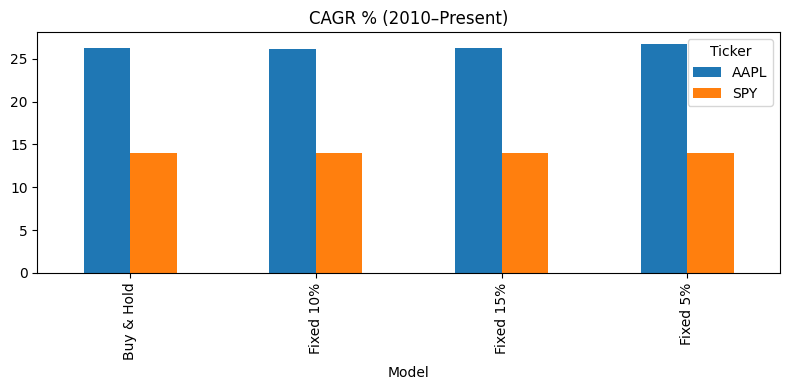

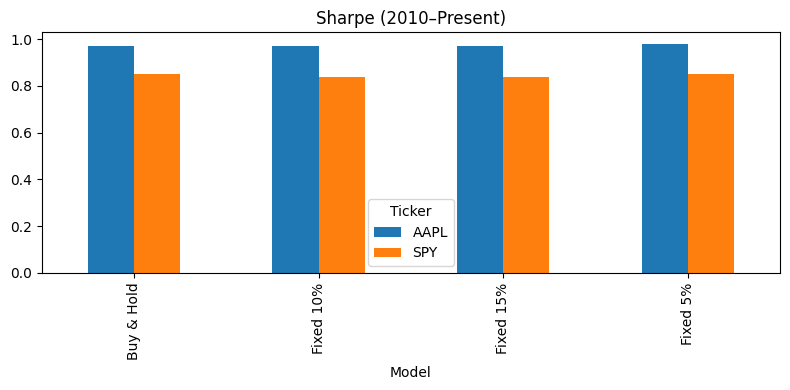

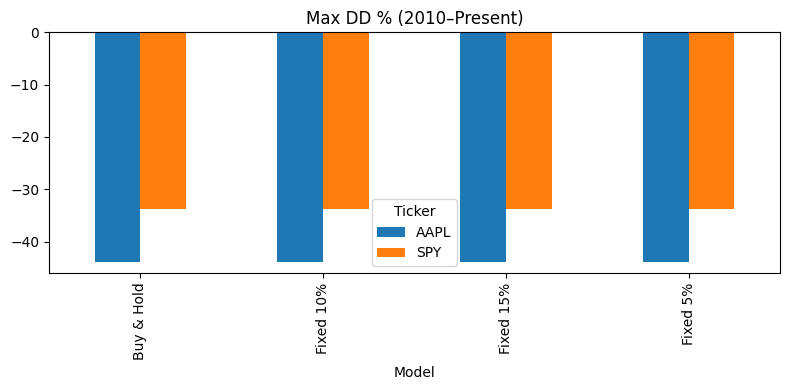

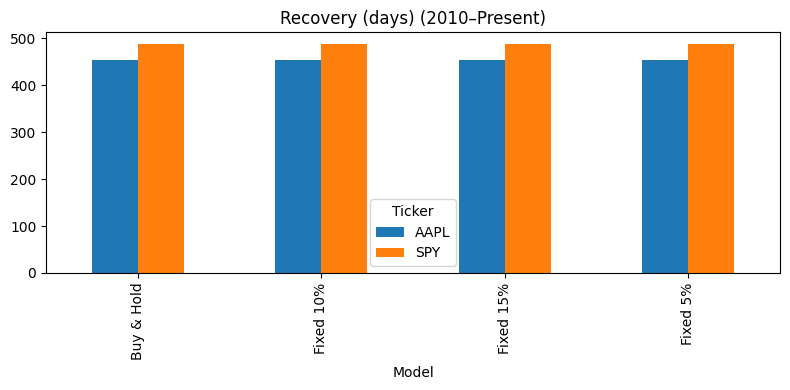

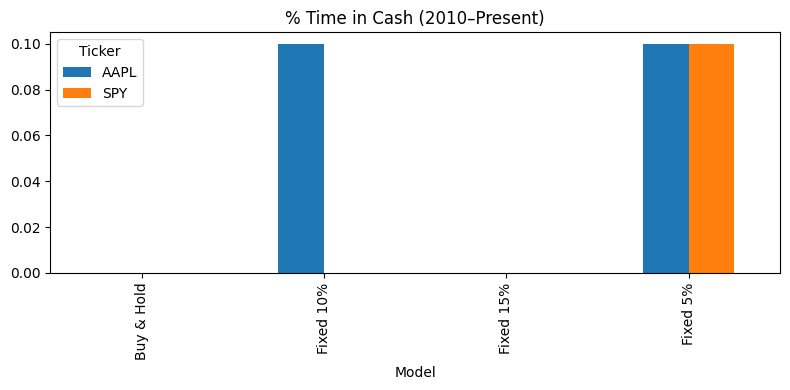

In [12]:
ohlc = get_ohlc(('SPY','AAPL'), start='2010-01-01')
summary, details = summarize_with_stops(ohlc, stops=(0.05,0.10,0.15), cool_off_days=5)
display(summary)

plot_metric_bars(summary, 'CAGR %')
plot_metric_bars(summary, 'Sharpe')
plot_metric_bars(summary, 'Max DD %')
plot_metric_bars(summary, 'Recovery (days)')
plot_metric_bars(summary, '% Time in Cash')

